# Solving Helmholtz by FDM

**Note: add to Elara handbook**

## Scalar-valued validation test

The Helmholz equation is given by:

$$
(\nabla^2 + k^2) E = 0
$$

This is the exact same as the finite element formulation which we will keep for consistency. We wish to solve it via the finite difference method with a discrete Laplacian:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from findiff import FinDiff
from findiff.diff import Coef, Id
from findiff.pde import BoundaryConditions, PDE
import scipy.sparse as sparse
import scipy.optimize as optimize
from numpy.linalg import norm
from random import randint
from sklearn.preprocessing import StandardScaler 
from sklearn.neural_network import MLPRegressor

In [25]:
%matplotlib inline
# settings for professional output
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.grid"] = True
plt.rcParams["mathtext.fontset"] = "stix" # use STIX fonts (install from https://www.stixfonts.org/)
# optional - always output SVG (crisper graphics but often slow)
# %config InlineBackend.figure_format = 'svg'

In [26]:
def test_plotstyle():
    x = np.linspace(-10, 10, 50)
    y = x**2 - 3
    plt.title(r"The graph of the function $f(x) = x^2 - 3$")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$f(x)$")
    plt.plot(x, y)
    plt.show()

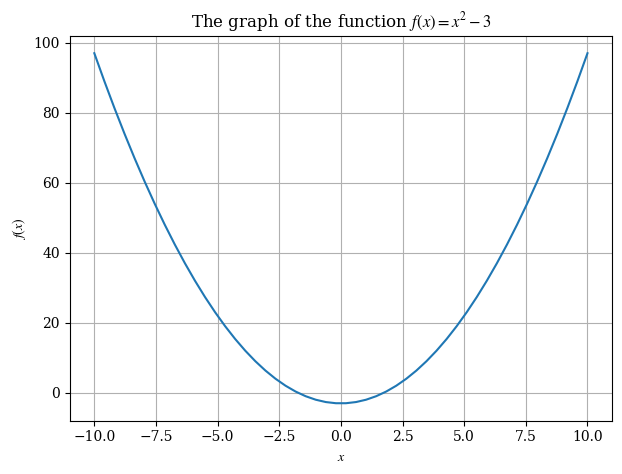

In [27]:
test_plotstyle()

In [28]:
k = 3.0

In [29]:
squaren = 120
shape = (squaren, squaren)

In [30]:
x = np.linspace(0, 1, squaren)
y = np.linspace(0, 1, squaren)
X, Y = np.meshgrid(x, y, indexing='ij')

In [31]:
dx = 1 / squaren
dy = 1 / squaren

In [32]:
bc = BoundaryConditions(shape)

In [33]:
bc

Dirichlet boundary conditions: $E \big|_{\partial \Omega} = f(x, y)$:

In [34]:
bc[:, 0] = 3 # E(x, 0)
bc[:, -1] = 10 # E(x, 1)
bc[0, :] = 6 # E(0, y)
bc[-1, :] = 1 # E(1, y)

We have two solvers - a custom solver `solve_helmholz_equation()` and a wrapper for FinDiff's own solver `findiff_solve_helmholz_equation()`, which are below. The findiff "issue" I had previously was with the construction of the operator. I would prefer to just convert the stuff to a matrix to solve because I don't know if `Coef(k**2)*Id()` is the correct way to construct it. But seems like now that I had the correct solution all along and just _thought_ the solution was wrong.

In [35]:
def findiff_solve(bc=bc, grid_shape=shape, k=k, dx=dx, dy=dy):
    helmholz = FinDiff(0, dx, 2) + FinDiff(1, dy, 2) + Coef(k**2)*Id()
    rhs = np.zeros(grid_shape)
    pde = PDE(helmholz, rhs, bc)
    return pde.solve()

In [36]:
def create_helmholz_operator(dx, dy, grid_shape, k):
    n, m = grid_shape
    laplacian = FinDiff(0, dx, 2) + FinDiff(1, dy, 2)
    ksquared = k**2 * sparse.eye(np.prod(grid_shape))
    # reshape() automatically selects to whichever shape necessary
    helmholz_mat = laplacian.matrix(grid_shape) + ksquared
    return helmholz_mat

In [37]:
def solve_helmholz_equation(dx=dx, dy=dy, bc=bc, grid_shape=shape, k=k):
    helmholz = create_helmholz_operator(dx, dy, grid_shape, k)
    rhs = np.zeros(shape)
    f = rhs.reshape(-1, 1)
    # set boundary conditions
    # this code is copied over from
    # findiff's source code in findiff.pde.PDE.solve()
    nz = list(bc.row_inds())
    helmholz[nz, :] = bc.lhs[nz, :]
    f[nz] = np.array(bc.rhs[nz].toarray()).reshape(-1, 1)
    print("Solving (this may take some time)...")
    solution = sparse.linalg.spsolve(helmholz, f).reshape(grid_shape)
    print("Solving complete.")
    return solution

In [38]:
def plot_E(E, X=X, Y=Y, label="Surface plot of solution data", rot=30):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlim(np.min(E), np.max(E))
    ax.view_init(30, rot)
    surf = ax.plot_surface(X, Y, E, cmap="coolwarm")
    fig.colorbar(surf, shrink=0.6)
    if not label:
        plt.title("Surface plot of solution data (v2)")
    else:
        plt.title(label)
    plt.show()

In [39]:
E = solve_helmholz_equation()
E_findiff = findiff_solve()

Solving (this may take some time)...
Solving complete.


However, the solution is different in form to the typical mathematical (Cartesian) representation. This is because arrays are stored in (row, column) order, that is, $(y, x)$, as is standard for computers, and in addition to this their origin is located at the top-left, rather than the bottom-left as is used in Cartesian coordinates. So we must convert to the standard mathematical representation before displaying. This consists of transposing, then flipping the array along the columns axis.

In [88]:
def calibrate(x=X, y=Y):
    f = (y - 0.4)**2 # the asymmetrical test function for calibration
    plt.imshow(correct_axes(f), interpolation="none")
    plt.title(r"Calibration test")
    plt.grid(False)
    plt.colorbar()
    plt.show()

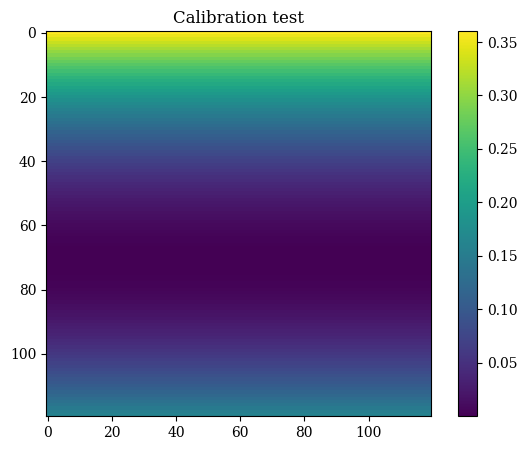

In [89]:
calibrate()

In [40]:
def correct_axes(mat2d):
    return np.flip(mat2d.T, axis=0)

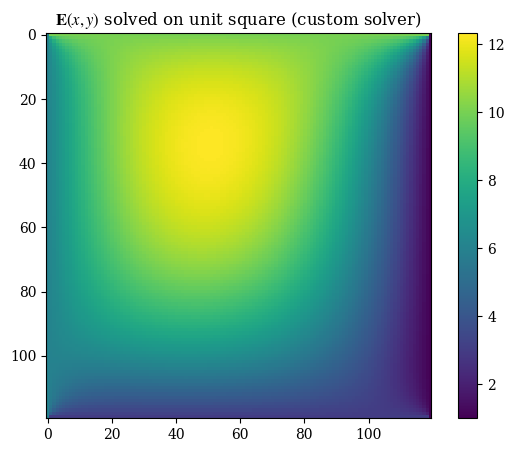

In [45]:
plt.imshow(correct_axes(E), interpolation="none")
plt.title(r"$\mathbf{E}(x, y)$ solved on unit square (custom solver)")
plt.colorbar()
plt.grid(False)
plt.show()

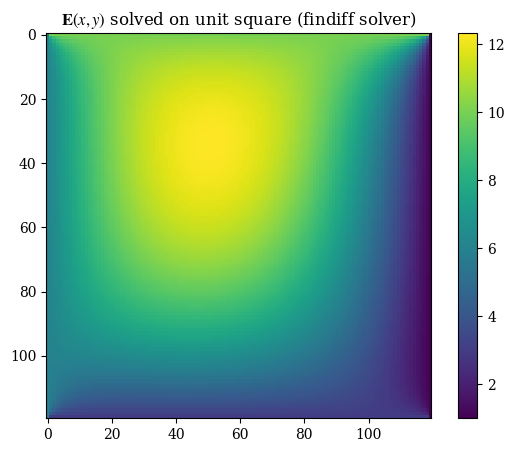

In [47]:
plt.imshow(correct_axes(E_findiff), interpolation="none")
plt.title(r"$\mathbf{E}(x, y)$ solved on unit square (findiff solver)")
plt.colorbar()
plt.grid(False)
plt.show()

In [55]:
imgX, imgY = np.meshgrid(np.arange(squaren), np.arange(squaren))

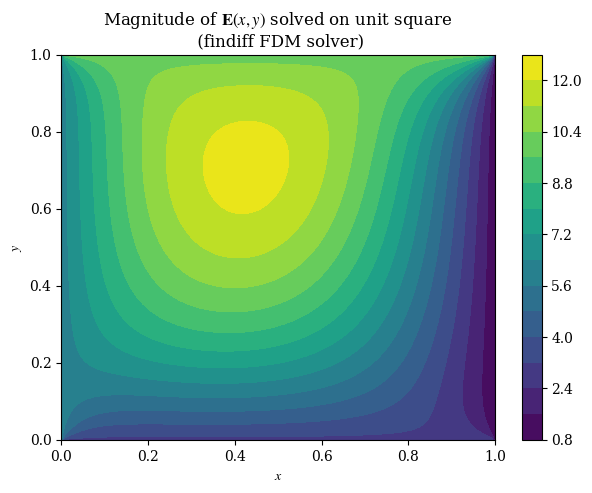

In [104]:
#plt.imshow(correct_axes(E_findiff), interpolation="none")
plt.contourf(X, Y, E_findiff, levels=15)
plt.title(r"Magnitude of $\mathbf{E}(x, y)$ solved on unit square" + "\n (findiff FDM solver)")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()
plt.grid(False)
plt.show()
#plt.savefig("fdm-validation.eps", dpi=300)

In [66]:
abs_difference = np.abs(E - E_findiff)

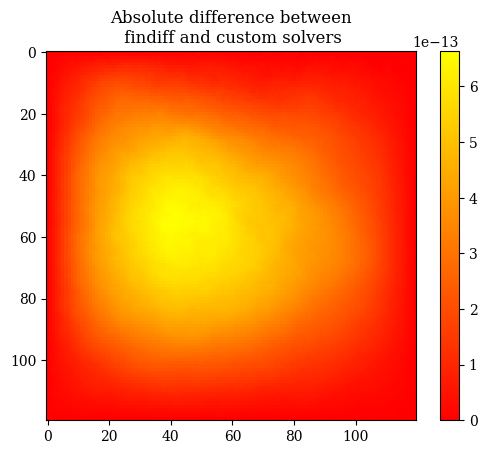

In [67]:
plt.imshow(correct_axes(abs_difference), interpolation="none", cmap="autumn")
plt.title("Absolute difference between\n findiff and custom solvers")
plt.colorbar()
plt.show()

In [68]:
abs_difference.max()

6.643574579356937e-13

The general differences between the findiff solver and the custom solver are very very miniscule on the order of $\mathcal{E} \sim 10 \times e^{-13}$. Therefore we will use the two solutions interchangeably and consider them equivalent. If we inspect the solution, we can clearly see that the boundaries follow the boundary conditions:

In [69]:
E[0, :] # E(0, y) = 6

array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6.])

In [70]:
E[-1,:] # E(1, y) = 1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

We can also verify with a 3D plot (where we now don't need to do the transpose trick because we're displaying 3D points and matplotlib is smart enough to figure that out):

In [548]:
E_findiff.dtype

dtype('float64')

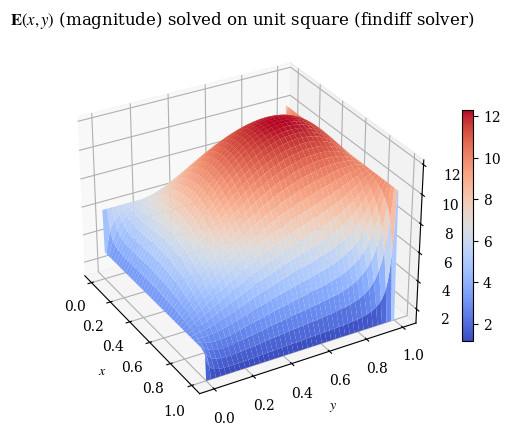

In [49]:
# note this is V3
plot_E(E_findiff, label=r"$\mathbf{E}(x, y)$ (magnitude) solved on unit square (findiff solver)", rot=-30)

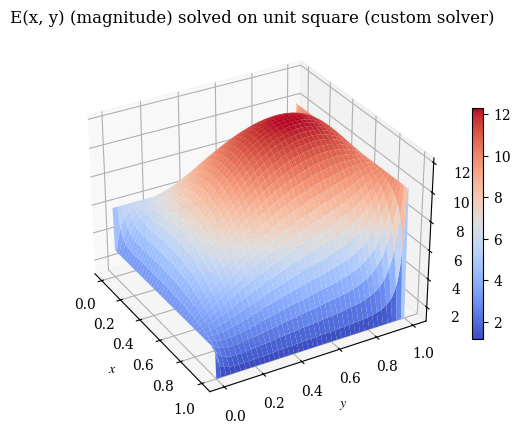

In [50]:
# also V3
plot_E(E, label="E(x, y) (magnitude) solved on unit square (custom solver)", rot=-30)

In [46]:
# in function so as not to conflict with global vars
def plotly_plot():
    figdata = go.Surface(x=X, y=Y, z=E)
    fig = go.Figure(figdata)
    fig.update_layout(title="Numerical solution of Helmholtz equation")
    fig.show()

In [47]:
# uncomment to plot a live interactive solution
# import plotly.graph_objects as go
# plotly_plot()

The second test is the vector-valued version that uses the same coordinate transformations as the full version. However, do note that the Helmholz equation's vector components are **independent** of each other, meaning that the components can just as well be simulated separately (as two scalar PDEs) as together (as one vector PDE).

In [35]:
def gen():
    step = randint(0, squaren)
    step2 = randint(0, squaren)
    print(f"Generated test point ({step*dx:.3f}, {step2*dx:.3f}) corresponding to index [{step}, {step2}]")

Some test points generated for testing:

In [36]:
gen()

Generated test point (0.458, 0.317) corresponding to index [55, 38]


In [37]:
gen()

Generated test point (0.433, 0.642) corresponding to index [52, 77]


In [38]:
gen()

Generated test point (0.467, 0.392) corresponding to index [56, 47]


We test the validation points on the domain to compare against the FreeFEM version - note that this is because the finite element output is not on a regular mesh so cannot be compared value-by-value against the finite-difference result:

In [65]:
# convert real-space (x, y)
# coordinates to index (m, n)
# of the solution array
def convert_coord_index(x, y):
    x_idx = round(x*squaren)
    y_idx = round(y*squaren)
    # prevent out of bound
    # access errors
    if x_idx == squaren:
        x_idx = -1
    if y_idx == squaren:
        y_idx = -1
    return (x_idx, y_idx)

In [66]:
# unlike the freefem version, for this one
# we use the *index* locations of each point
# e.g. (1.0, 1.0) is equal to index [-1, -1]
# because it is the endpoint on both x and y
#
# for the ones where this method is a bit wonky, the
# convert_coord_index function is used
# which rounds the evaluation location to
# the closest set of [idx, idx] values
cases = [
    # boundary points
    (0, 0.5),
    (0.5, 0),
    (1., 0.5),
    (0.5, 1),
    # center points
    (0.25, 0.25),
    (0.5, 0.5),
    (0.75, 0.75),
    # the three nonstandard points
    # given by the gen() function above
    (0.6, 0.),
    (0.55, 0.562),
    (0.663, 0.413)
]

In [67]:
testpoints = [convert_coord_index(*c) for c in cases]

In [68]:
def validate():
    results = [0 for i in range(len(testpoints))]
    for p_idx, p in enumerate(testpoints):
        i = p[0]
        j = p[1]
        # uncomment to show the corresponding index
        # print("Index:", f"({i}, {j})")
        if i == 0:
            x = 0
        else:
            x = i/squaren if i!= -1 else 1
        if j == 0:
            y = 0
        else:
            y = j/squaren if j!= -1 else 1
        res = E[i][j]
        print(f"On test point ({x:.3f}, {y:.3f}), result value {res}")
        results[p_idx] = res
    return results

In [69]:
res = validate()

On test point (0.000, 0.500), result value 6.0
On test point (0.500, 0.000), result value 3.0
On test point (1.000, 0.500), result value 1.0
On test point (0.500, 1.000), result value 10.0
On test point (0.250, 0.250), result value 8.079939622439468
On test point (0.500, 0.500), result value 11.180791034433206
On test point (0.750, 0.750), result value 8.85861817899529
On test point (0.600, 0.000), result value 3.0
On test point (0.550, 0.558), result value 11.205957209242635
On test point (0.667, 0.417), result value 8.546978859213533


In [70]:
# from wave-parabolic-6-validation_4.edp
fem_results = [
    6.0,
    3.0,
    1.0,
    10.0,
    8.14275,
    11.3661,
    9.07413,
    3.0,
    11.4339,
    8.78092
]

In [71]:
res_array = np.array(res)
fem_res_array = np.array(fem_results)

In [72]:
bar_x = np.arange(10)

In [73]:
points_labels = [str(p) for p in testpoints]

In [107]:
def plot_barchart(width=0.25, save=False):
    fig, ax = plt.subplots(layout='constrained')
    ax.set_title("Comparison of numerical solutions")
    ax.set_xlabel("Test case")
    ax.set_ylabel("Numerical solution value")
    p1 = ax.bar(bar_x, res_array, width=width, label="FDM solution")
    #ax.bar_label(p1, label_type="edge", fmt=lambda x: '{x:.2f}')
    p2 = ax.bar(bar_x + 0.25, fem_res_array, width=width, label="FreeFEM solution")
    #ax.bar_label(p2, label_type="edge", fmt=lambda x: '{x:.2f}')
    p3 = ax.bar(bar_x + 0.5, np.abs(fem_res_array - res_array), width=width, label="Absolute difference\n(if nonzero)")
    #ax.bar_label(p2, label_type="edge", fmt=lambda x: '{x:.2f}')
    ax.set_xticks(bar_x, points_labels)
    ax.legend()
    plt.grid(False)
    if save:
        plt.savefig("validation-bar-chart.eps", dpi=600)
    else:
        plt.show()

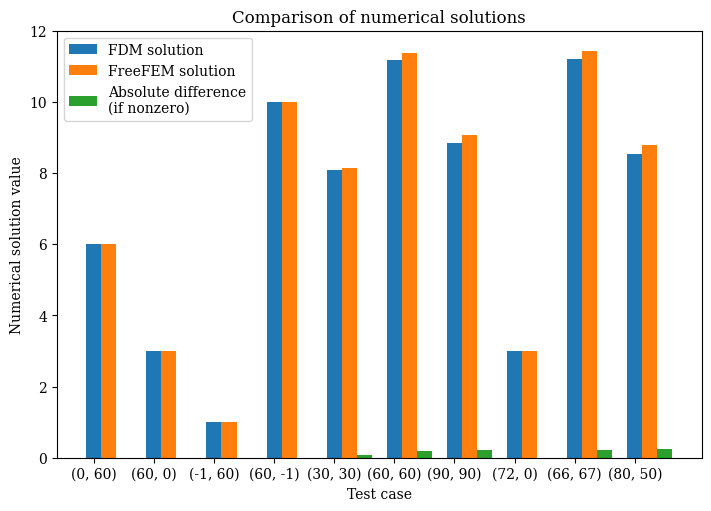

In [109]:
plot_barchart()

## Vector-valued validation test

We also want to do a simulation with the same boundary conditions but using a transformed coordinates system and vector-valued. As findiff can only solve scalar PDEs, in practice this means that we are solving 2 separate PDEs with different boundary conditions, and then combining them to get a vector-valued function. We are still using the same value of $k$ and the same domain (of a unit square) as before. For the vector PDE, the coordinates in $(x, y)$ space are:

$$
E_x(x, 0) = 2, E_x(x, 1) = 7, E_x(0, y) = 0.5, E_x(1, y) = \pi \\
E_y(x, 0) = 2\pi, E_y(x, 1) = 3, E_y(0, y) = 12, E_y(1, y) = 1
$$

What we want is to convert to $(u, v)$ coordinates where $u = e^x$ and $v = e^y$. To preserve the same physical results, we must ensure that $E(u, v) = E(x, y)$. which means re-expressing each of those boundary conditions in terms of functions $E_u(u, v)$ and $E_v(u, v)$. To do this we use the forward transforms $E(u, v)  = E(e^x, e^y)$. This means the function stays identical, and is simply expressed in different coordinates.

As an example, consider the first boundary condition $E_x(x, 0) = 2$. The constant-valued outputs of the functions remains the same under the coordinate transformation, and the only thing that changes are the coordinates. That is to say, $E_u(u, v) = E_x(u(x),v(y)$. For this, we substitute $u(x)$ and $v(y)$ into $E_x(x, 0)$ as follows:


$$
E_u(u, v) =E_x(u(x), v(y))\big|_{(x, y) = (x, 0)} = E_x(u(x), v(0)) = E_x(e^x, 1) = E_u(u, 1)
$$

Doing so for each of the expressions, we obtain:

$$
E_u(u, 1) = 2, E_u(u, e) = 7, E_u(1, v) = 0.5, E_u(e, v) = \pi \\
E_v(u, 1) = 2\pi, E_v(u, e) = 3, E_v(1, v) = 12, E_v(e, v) = 1
$$

Where the domain $(x, y) \in [0, 1] \times [0, 1]$ becomes rescaled to $(u, v) \in [1, e] \times [1, e]$, as can be seen below:

In [9]:
u_example = np.exp(x)
print(u_example)

[1.         1.00843877 1.01694875 1.02553055 1.03418476 1.04291201
 1.0517129  1.06058806 1.06953812 1.0785637  1.08766545 1.09684401
 1.10610002 1.11543415 1.12484704 1.13433936 1.14391179 1.15356499
 1.16329966 1.17311648 1.18301614 1.19299934 1.20306678 1.21321919
 1.22345726 1.23378173 1.24419333 1.25469279 1.26528086 1.27595827
 1.28672578 1.29758417 1.30853418 1.3195766  1.3307122  1.34194177
 1.35326611 1.36468601 1.37620228 1.38781573 1.39952718 1.41133747
 1.42324742 1.43525788 1.44736969 1.4595837  1.47190079 1.48432182
 1.49684767 1.50947922 1.52221737 1.53506301 1.54801705 1.56108041
 1.57425401 1.58753877 1.60093564 1.61444557 1.6280695  1.6418084
 1.65566324 1.669635   1.68372467 1.69793323 1.7122617  1.72671108
 1.74128239 1.75597667 1.77079495 1.78573828 1.80080771 1.81600431
 1.83132915 1.84678332 1.86236789 1.87808399 1.8939327  1.90991516
 1.92603249 1.94228584 1.95867634 1.97520515 1.99187345 2.00868241
 2.02563322 2.04272707 2.05996517 2.07734874 2.09487901 2.11255

As a demonstration of the equivalence of solutions after a coordinate transform, consider the following change of variables $x \to u = 3x + 5$ on a given function:

In [12]:
def test_coord_transform():
    # not from zero because we don't want 1/0
    x = np.linspace(0.01, 2*np.pi, 50)
    # u = u(x) the forwards transform
    u_of_x = lambda x: 3*x + 5 # u in terms of x
    # x = x(u) the backwards transform
    x_of_u = lambda u: (u - 5)/3 # x in terms of u
    fig = plt.figure()
    fig.suptitle("A demonstration of coordinate transforms")
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.set_title("$f(x)$ in $(x, y)$ coordinates")
    f = lambda x: np.sin(x)
    # plot in x-space
    ax1.plot(x, f(x))
    # plot in u-space
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.set_title("$g(u)$ in $(u, v)$ coordinates")
    u = u_of_x(x)
    g = lambda u: np.sin(u)
    ax2.plot(u, g(u), linestyle="--")
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.set_title("$f(x)$ reconstructed from $g(u)$")
    ax3.plot(x, g(x_of_u(u)))
    plt.subplots_adjust(hspace=0.75)
    plt.show()

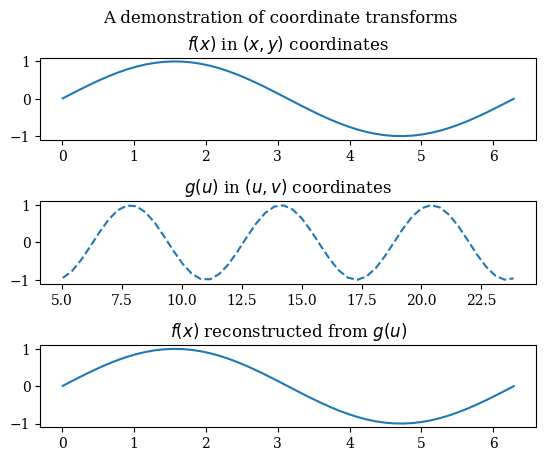

In [13]:
test_coord_transform()

To solve the PDE in the new coordinates, the PDE itself must be converted to the new coordinates. By the chain rule, it can be shown that the new form the vector-valued PDE takes is given by:

$$
\begin{align}
\left(u \frac{\partial}{\partial u} \left(u \frac{\partial}{\partial u}\right)
+ v \frac{\partial}{\partial v} \left(v \frac{\partial}{\partial v}\right)
+ k^2 \right) \tilde E_u(u, v) &= 0 \\
\left(u \frac{\partial}{\partial u} \left(u \frac{\partial}{\partial u}\right)
+ v \frac{\partial}{\partial v} \left(v \frac{\partial}{\partial v}\right)
+ k^2 \right) \tilde E_v(u, v) &= 0
\end{align}
$$

Note that in the numerical programming we must expand out the partial derivatives. The expanded version of the Helmholz operator is:

$$
u \left(\frac{\partial}{\partial u} + u \frac{\partial^2}{\partial u^2}\right) + u \left(\frac{\partial}{\partial u} + u \frac{\partial^2}{\partial u^2}\right) + k^2
$$

In addition, we will convert the boundary conditions respectively to:

$$
\tilde E_u(u, 1) = 2, \tilde E_u(u, e) = 7, \tilde E_u(1, v) = 0.5, \tilde E_u(e, v) = \pi \\
\tilde E_v(u, 1) = 2\pi, \tilde E_v(u, e) = 3, \tilde E_v(1, v) = 12, \tilde E_v(e, v) = 1
$$

In [17]:
# forward transformations
u_of_x = lambda x: np.exp(x)
v_of_y = lambda y: np.exp(y)

In [18]:
U = u_of_x(X)
V = v_of_y(Y)

We can see that the domain $[0, 1] \times [0, 1]$ in $(x, y)$ maps to $[1, e] \times [1, e]$ in $(u, v)$ coordinates:

In [20]:
U.min(), U.max()

(1.0, 2.718281828459045)

Consider the first boundary condition $E_x(x, 0) = 2$. We can show that it takes the form $E_u(u, 1) = 2$ below:

In [27]:
example_Ex_func = lambda x, y: 2

In [28]:
example_Eu_func = example_Ex_func(u_of_x(x), v_of_y(y))

In [29]:
example_Eu_func

2

In [31]:
# again incapsulate in function to prevent variable
# overwrite in global scope
# if refactoring is best to make a class for everything
def solve_transformed_helmholtz(x=x, y=y, k=k, shape=shape):
    u = u_of_x(x)
    v = v_of_y(y)
    du = u[1] - u[0]
    dv = v[1] - v[0]
    # not sure if we need to convert to meshgrid for this
    U, V = np.meshgrid(u, v, indexing='ij')
    d_du = FinDiff(0, du)
    d_ddu = FinDiff(0, du, 2)
    d_dv = FinDiff(1, dv)
    d_ddv = FinDiff(1, dv, 2)
    # helmholtz operator
    # helmholz = Coef(U)*d_du + Coef(U**2)*d_ddu + Coef(V)*d_dv + Coef(V**2)*d_ddv + Coef(k**2)*Id()
    helmholz = Coef(U)*(d_du + Coef(U)*d_ddu) + Coef(V)*(d_dv + Coef(V)*d_ddv) + Coef(k**2)*Id()
    rhs = np.zeros(shape)
    # we need separate boundary conditions for E_u and E_v components
    # of the vector-valued PDE
    bc_u = BoundaryConditions(shape)
    bc_v = BoundaryConditions(shape)
    # here note that we set based on the boundaries
    # by index not by value
    # the domain is [1, e] x [1, e]
    bc_u[:, 0] = 2.0 # E_u(u, 1)
    bc_u[:, -1] = 7.0 # E_u(u, e)
    bc_u[0, :] = 0.5 # etc.
    bc_u[-1, :] = np.pi
    
    bc_v[:, 0] = 2*np.pi
    bc_v[:, -1] = 3
    bc_v[0, :] = 12
    bc_v[-1, :] = 1
    
    # PDE for u component of electric field
    # the helmholz operator is identical for both PDEs
    pde_u = PDE(helmholz, rhs, bc_u)
    pde_v = PDE(helmholz, rhs, bc_v)
    solution_u = pde_u.solve()
    solution_v = pde_v.solve()
    return solution_u, solution_v

Note: for the production version I want all text to be rendered in LaTeX with proper axes labels and titles in LaTeX typesetting.

In [32]:
transform_u, transform_v = solve_transformed_helmholtz()

After solving for the components of $\mathbf{E}$, we can visualize $\mathbf{E}$ as a vector field as follows:

In [33]:
def magnitude(E1, E2):
    squared_norm = E1**2 + E2**2
    return np.sqrt(squared_norm)

In [49]:
def plotE_uvspace(u=U, v=V, Usol=transform_u, Vsol=transform_v, desc=None, opacity=0.5):
    vec_density = 6 # plot one vector for every 10 points
    contour_levels = 12 # number of contours (filled isocurves) to plot
    transform_mag = magnitude(transform_u, transform_v)
    levels = np.linspace(transform_mag.min(), transform_mag.max(), contour_levels)
    # plot the filled isocurves
    plt.contourf(u, v, transform_mag, levels=levels)
    plt.colorbar()
    # plot the vectors
    plt.quiver(u[::vec_density, ::vec_density], v[::vec_density, ::vec_density], Usol[::vec_density, ::vec_density], Vsol[::vec_density, ::vec_density], scale=400, headwidth=2, color=(1, 1, 1, opacity))
    plt.xlabel("$u$")
    plt.ylabel("$v$")
    if not desc:
        plt.title(r"$\mathbf{E}(u, v)$ solved on unit square in $(u, v)$ coordinates")
    else:
        plt.title(desc)
    plt.show()

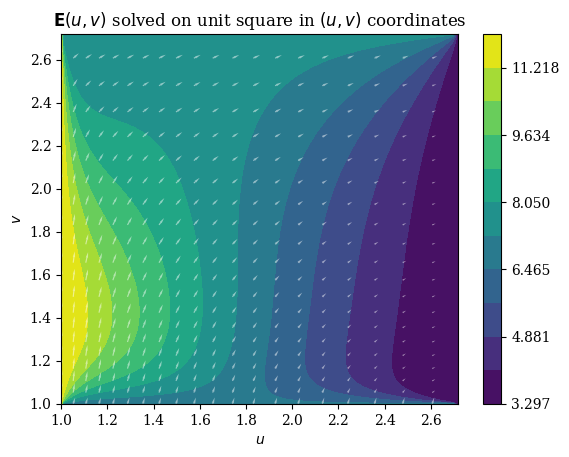

In [50]:
plotE_uvspace()

And the magnitude is respectively given by $E = \|\mathbf{E}\| = \|E_u \hat{\mathbf{u}} + E_v \hat{\mathbf{v}}\| = \sqrt{E_u{}^2 + E_v{}^2}$, which can be plotted as shown:

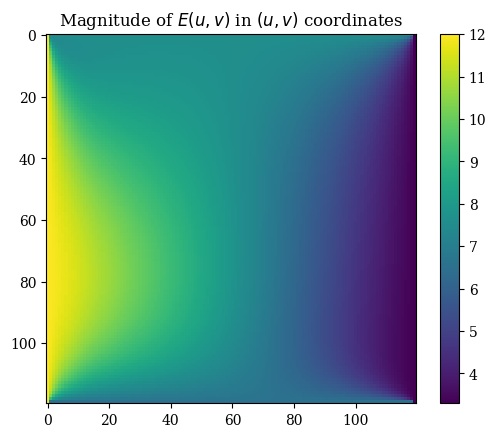

In [45]:
plt.imshow(correct_axes(magnitude(transform_u, transform_v)), interpolation="none")
plt.title("Magnitude of $E(u, v)$ in $(u, v)$ coordinates")
plt.colorbar()
plt.show()

Note that the axes tickmarks can be ignored (they are not accurate) , as `imshow()` treats the input as if it were an image (which it obviously is not). We can validate the solution with the analytical expressions for the magnitude calculated from the boundary conditions for $E_u$ and $E_v$:

In [52]:
E_prime_bottom = magnitude(2, 2*np.pi)
E_prime_top = magnitude(7, 3)
E_prime_left = magnitude(0.5, 12)
E_prime_right = magnitude(np.pi, 1)
print(f"Analytical values - top: {E_prime_top:.3f}, right: {E_prime_right:.3f}, bottom: {E_prime_bottom:.3f}, left: {E_prime_left:.3f}")

Analytical values - top: 7.616, right: 3.297, bottom: 6.594, left: 12.010


Which agree reasonably with the values shown in the plot. We will now do the comparison with the finite element solution for the validation.

In [75]:
# convert transformed-space (u, v)
# coordinates to index (m, n)
# of the solution array
def convert_coord_index_uv(u, v):
    u_idx = round((u-1)/(np.e-1)*squaren)
    v_idx = round((v-1)/(np.e-1)*squaren)
    # prevent out of bound
    # access errors
    if u_idx == squaren:
        u_idx = -1
    if v_idx == squaren:
        v_idx = -1
    return (u_idx, v_idx)

In [76]:
def validate_vector_uv():
    # here (u, v) is the domain [1, e] x [1, e]
    points = [
        [np.e/2, 1], # bottom
        [1, np.e/2], # left
        # the remainder are random points
        [1.3, 2.2],
        [1.7, 1.65],
        [2.4, 2.5]
    ]
    
    for p in points:
        idx_u, idx_v = convert_coord_index_uv(*p)
        transform_mag = magnitude(transform_u, transform_v)
        res = transform_mag[idx_u, idx_v]
        print(f"On test point ({p[0]:.3f}, {p[1]:.3f}), magnitude {res:.4f}")

In [77]:
validate_vector_uv()

On test point (1.359, 1.000), magnitude 6.5938
On test point (1.000, 1.359), magnitude 12.0104
On test point (1.300, 2.200), magnitude 9.0310
On test point (1.700, 1.650), magnitude 8.6128
On test point (2.400, 2.500), magnitude 6.2909


To evaluate the solution $(x, y)$ coordinates, we remap each of the points from $(u, v)$ space to $(x, y)$ space, that is, applying the inverse transforms $x(u) = \ln u$ and $y(v) = \ln v$ (again the prime here denotes transformation, it is not a derivative symbol. As the solution is numerical (and therefore discrete), we must interpolate it to find $\tilde{\mathbf{E}}(u, v)$ so that we can calculate the correct values according to the formula $\mathbf{E}(x, y) = \tilde{\mathbf{E}}(x(u), y(v))$. For this we use `scipy.optimize.curve_fit` with a cubic polynomial in the form $f(x, y) = ax^3 + by^3 + cx^2 y^2 + dx^2 + gy^2 + hxy + mx + nx + r$ on both components of $\mathbf{E}'$:

$$
E_u(u, 1) = 2, E_u(u, e) = 7, E_u(1, v) = 0.5, E_u(e, v) = \pi \\
E_v(u, 1) = 2\pi, E_v(u, e) = 3, E_v(1, v) = 12, E_v(e, v) = 1
$$

In [556]:
# have to flatten arrays to make this work
def interpolation_func(X, a=1, b=1, c=1, d=1, g=1, h=1, m=1, n=1, r=1):
    u_raw, v_raw = X
    squaren = 120 # change based on the value of squaren globally
    x = u_raw
    y = v_raw
    out = a*x**3 + b*y**3 + c*x**2*y**2 + d*x**2 + g*y**2 + h*x*y + m*x + n*x + r
    return out.flatten()

In [557]:
sol_u, cov_u = optimize.curve_fit(interpolation_func, (U.flatten(), V.flatten()), transform_u.flatten())

In [559]:
sol_v, cov_v = optimize.curve_fit(interpolation_func, (U.flatten(), V.flatten()), transform_v.flatten())

We can then use the interpolated function as usual functions, `E_u(u, v)` and `E_v(u, v)` that can be given arguments, which represents $\mathbf{E}'(u, v)$:

In [161]:
# these take in vector-valued inputs i.e. you need to use np.meshgrid for them
E_u = lambda u, v: interpolation_func((u.flatten(), v.flatten()), *sol_u).reshape(squaren, squaren)
E_v = lambda u, v: interpolation_func((u.flatten(), v.flatten()), *sol_v).reshape(squaren, squaren)
Emag_uv = lambda u, v: magnitude(E_u(u, v), E_v(u, v))

And we can plot it just like the original numerical solution:

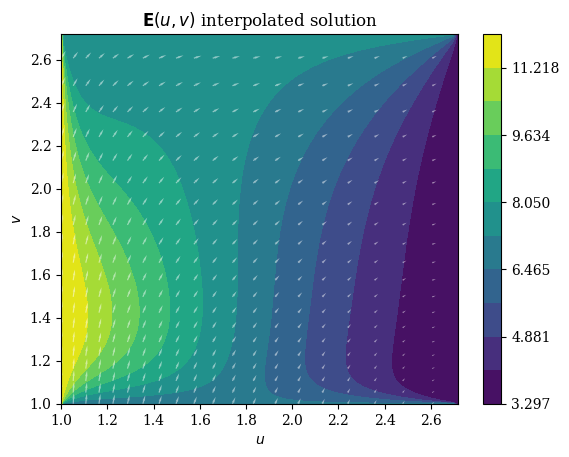

In [162]:
plotE_uvspace(Usol=E_u(U, V), Vsol=E_v(U, V), desc=r"$\mathbf{E}(u, v)$ interpolated solution")

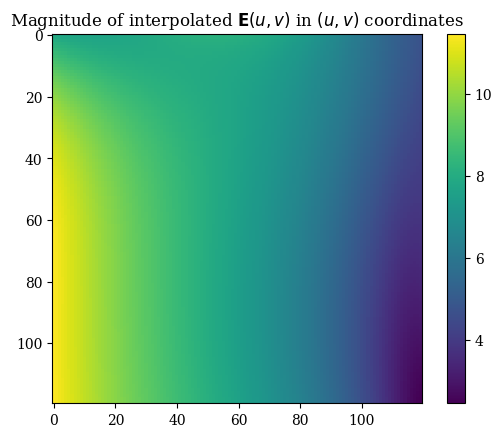

In [163]:
plt.imshow(correct_axes(Emag_uv(U, V)), interpolation="none")
plt.title("Magnitude of interpolated $\mathbf{E}(u, v)$ in $(u, v)$ coordinates")
plt.colorbar()
plt.show()

We can compare the interpolation functions' accuracy with the original numerical solution:

In [89]:
interpolation_err_u = np.abs(E_u(U, V) - transform_u)
interpolation_err_v = np.abs(E_v(U, V) - transform_v)

For instance, we can find the general statistics of the maximum and mean error of the interpolation as compared to the numerical solution:

In [90]:
interpolation_err_u.max()

4.40573641552411

In [92]:
interpolation_err_v.max()

5.882550237011159

In [109]:
interpolation_err_u.mean()

0.29152453481617346

In [110]:
interpolation_err_v.mean()

0.5094868494199758

A histogram to be able to see how the error is spread out is best, but this will do for now. Here is a image plot of the same thing:

In [560]:
interpolation_err = magnitude(interpolation_err_u, interpolation_err_v)

In [561]:
cov_v.min()

-24059712968.083336

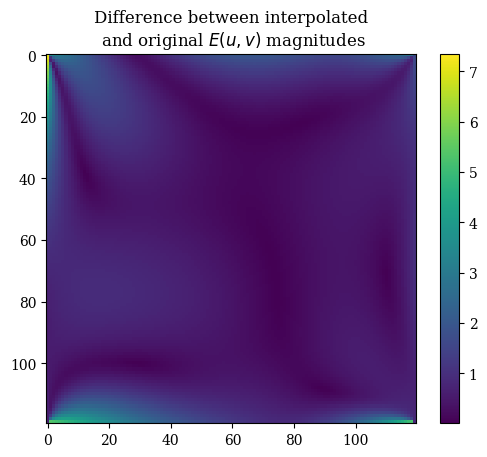

In [562]:
plt.imshow(correct_axes(interpolation_err), interpolation="none")
plt.title("Difference between interpolated\n and original $E(u, v)$ magnitudes")
plt.colorbar()
plt.show()

In addition, the output _covariance_ is of interest to us. It is a measure of the spread of the interpolation scheme, and as such a low covariance is greatly desired. The covariance statistics are shown in the plot below. Curiously the fit seems to be almost perfect except for a few outlier points that are absolutely ridiculous:

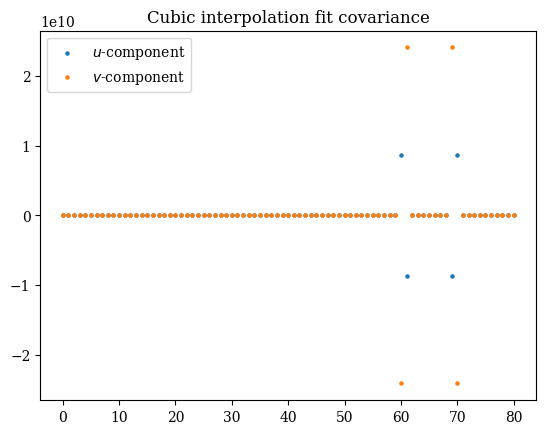

In [114]:
# todo: make the plot of the covariance work
plt.title("Cubic interpolation fit covariance")
plt.scatter(np.arange(np.prod(cov_u.shape)), cov_u.flatten(), label="$u$-component", s=5)
plt.scatter(np.arange(np.prod(cov_v.shape)), cov_v.flatten(), label="$v$-component", s=5)
plt.legend()
plt.show()

For comparison we can evaluate the numerial vs interpolated solution next to each other on a common set of points:

In [154]:
# we use pointwise variants of the interpolation function as opposed
# to the one that takes vectorized input
E_u_pointwise = lambda u, v: interpolation_func((u, v), *sol_u)
E_v_pointwise = lambda u, v: interpolation_func((u, v), *sol_v)
E_uv_pointwise = lambda u, v: float(np.sqrt(E_u_pointwise(u, v)**2 + E_v_pointwise(u, v)**2))

In [155]:
def validate_interpolate_vs_num_uv():
    # here (u, v) is the domain [1, e] x [1, e]
    points = [
        [(np.e-1)/2, 1], # bottom
        [1, (np.e-1)/2], # left
        # the remainder are random points
        [1.3, 2.2],
        [1.7, 1.65],
        [2.4, 2.5]
    ]
    
    print("Comparison of magnitudes (numerical vs interpolated)")
    for p in points:
        idx_u, idx_v = convert_coord_index_uv(*p)
        transform_mag = magnitude(transform_u, transform_v)
        res = transform_mag[idx_u, idx_v]
        interp_res = E_uv_pointwise(*p)
        print(f"On test point ({p[0]:.3f}, {p[1]:.3f}), numerical solution {res:.4f}, interpolated solution {float(interp_res):.4f}")

In [156]:
validate_interpolate_vs_num_uv()

Comparison of magnitudes (numerical vs interpolated)
On test point (0.859, 1.000), numerical solution 6.5938, interpolated solution 13.2129
On test point (1.000, 0.859), numerical solution 12.0104, interpolated solution 11.5069
On test point (1.300, 2.200), numerical solution 9.0310, interpolated solution 8.5050
On test point (1.700, 1.650), numerical solution 8.6128, interpolated solution 7.4078
On test point (2.400, 2.500), numerical solution 6.2909, interpolated solution 5.6208


We can also check for the boundary conditions against their analytical values:

In [157]:
print(f"Analytical values - top: {E_prime_top:.3f}, right: {E_prime_right:.3f}, bottom: {E_prime_bottom:.3f}, left: {E_prime_left:.3f}")

Analytical values - top: 7.616, right: 3.297, bottom: 6.594, left: 12.010


In [158]:
half_u = (np.e - 1)/2
half_v = (np.e - 1)/2
E_interp_uv_top = E_uv_pointwise(half_u, np.e)
E_interp_uv_right = E_uv_pointwise(np.e, half_v)
E_interp_uv_bottom = E_uv_pointwise(half_u, 1)
E_interp_uv_left = E_uv_pointwise(1, half_v)

In [159]:
print(f"Interpolated values - top: {E_interp_uv_top:.3f}, right: {E_interp_uv_right:.3f}, bottom: {E_interp_uv_bottom:.3f}, left: {E_interp_uv_left:.3f}")

Interpolated values - top: 8.867, right: 2.262, bottom: 13.213, left: 11.507


It does seem that the interpolation is quite inadequate. To examine the issue further, we can plot the boundaries obtained from the original numerical solution as well as the transformation, which is shown below:

In [252]:
def compare_uv_bcs(Emag_numerical = magnitude(transform_u, transform_v), Emag_interp = Emag_uv(U, V), u=u_of_x(x), v=v_of_y(y), desc=None):
    fig = plt.figure(layout='constrained')
    if not desc:
        fig.suptitle("Comparison of numerical and interpolation\n solutions evaluted on boundaries")
    else:
        fig.suptitle(desc)
    spec = fig.add_gridspec(ncols=2, nrows=2)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.set_title("Top boundary")
    # we use [1:-2] because we don't want the endpoints which are connected
    # to the nodes of other boundaries
    ax1.plot(u[1:-2], Emag_numerical[:, -1][1:-2], label="numerical")
    ax1.plot(u, Emag_interp[:, -1], label="interpolated")
    ax1.legend()
    ax2 = fig.add_subplot(spec[0, 1])
    ax2.set_title("Bottom boundary")
    ax2.plot(u[1:-2], Emag_numerical[:, 0][1:-2], label="numerical")
    ax2.plot(u, Emag_interp[:, 0], label="interpolated")
    ax2.legend()
    ax3 = fig.add_subplot(spec[1, 0])
    ax3.set_title("Left boundary")
    ax3.plot(v[1:-2], Emag_numerical[:, 0][1:-2], label="numerical")
    ax3.plot(v, Emag_interp[:, 0], label="interpolated")
    ax3.legend()
    ax4 = fig.add_subplot(spec[1, 1])
    ax4.set_title("Right boundary")
    ax4.plot(v[1:-2], Emag_numerical[:, -1][1:-2], label="numerical")
    ax4.plot(v, Emag_interp[:, -1], label="interpolated")
    ax4.legend()
    plt.show()

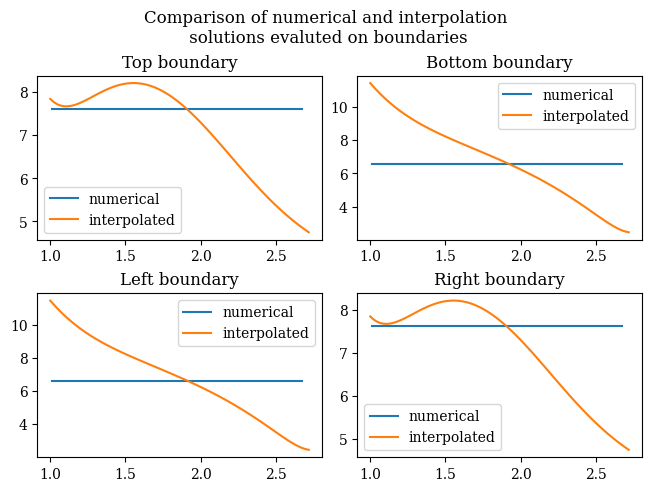

In [201]:
compare_uv_bcs()

Due to this reason, an alternative approach will be used instead, that being a _neural network_. Due to the universal approximation theorem, neural networks are able to approximate any function. So we will use a neural network as a nonlinear approximator (interpolator) for the function.

To do this we combine the $u$ and $v$ vectors together into one vector $[(u_1, v_1), (u_2, v_2), (u_3, v_3), \dots (u_n, v_n)]$:

In [364]:
trainX = np.stack((u_of_x(x), v_of_y(y))).T.reshape(-1, 2)

In [365]:
trainX.shape

(120, 2)

We can validate this is correct by manually checking ordered pairs of $(u, v)$ coordinates:

In [366]:
u_of_x(x)[0], v_of_y(y)[0]

(1.0, 1.0)

In [367]:
trainX[0]

array([1., 1.])

In [368]:
u_of_x(x)[-1], v_of_y(y)[-1]

(2.718281828459045, 2.718281828459045)

In [369]:
trainX[-1]

array([2.71828183, 2.71828183])

Then we can preprocess the data with scikit-learn:

In [370]:
scaler = StandardScaler()

In [371]:
scaler.fit(trainX)

StandardScaler()

In [372]:
processed_trainX = scaler.transform(trainX)

In [387]:
processed_trainX.shape

(120, 2)

We will also combine the $E_u$ and $E_v$ numerical solutions into one vector $[(E_{u_1}, E_{v_1}), (E_{u_2}, E_{v_2}), \dots, (E_{u_n}, E_{v_n})$. That means one $(u, v)$ coordinate maps to one value of $\mathbf{E}'(u, v)$. For this we do have to be aware of what axis we are slicing through.

In [397]:
np.stack((transform_u, transform_v)).shape

(2, 120, 120)

In [441]:
# TODO FIX: make sure this is 120 elements
trainY = np.stack((transform_u, transform_v)).reshape(240, -1).T

In [442]:
trainY.shape

(120, 240)

This is not as straightforward a process as it first seems due to the fact that scikit-learn only accepts 2D data for labels or for features at max. So what we will do is to reshape our $2 \times 120 \times 120$ array (because $E_u$ and $E_v$ each have $120 \times 120$ elements) to $(240, 120)$, essentially slicing each $120 \times 120$ array row-wise. The first 120 rows of the resulting array belowing to $E_u$ and the next 120 rows belong to $E_v$, and each of the rows has 120 elements. We then transpose, so the shape becomes $(240, 120) \to (120, 240)$ to be able to get our labels to have the same shape across the first component as the features.

To turn the predicted results from the NN back into a usable form, we transpose the prediction array $(120, 240) \to (240, 120)$ and then split the 240 rows themselves into 2 sets of 120 rows. This means the final shape is $(2, 120, 120)$, i.e. two $120 \times 120$ arrays, which we can then plot with `imshow` in matplotlib.

In [461]:
processed_trainX.shape

(120, 2)

In [462]:
trainY.shape

(120, 240)

As a validation that our reshaping the array results in a valid result, we can run the `prediction_to_grid()` function directly on the data labels (i.e. the values of $E_u$ and $E_v$) to show that it is correct.

In [463]:
def prediction_to_grid(predictY):
    # converts the output of the NN
    # to two 120 x 120 grids for each
    # of the two components of E
    # (E_u and E_v)
    # TODO this
    E_u, E_v = predictY.T.reshape(2, squaren, -1)
    return E_u, E_v

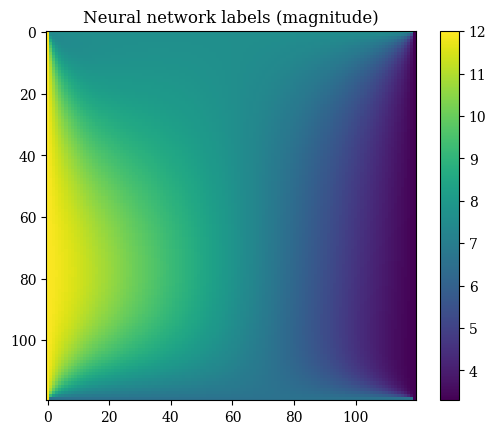

In [563]:
# continue work here
plt.title("Neural network labels (magnitude)")
E_u_testgrid, E_v_testgrid = prediction_to_grid(trainY)
plt.imshow(correct_axes(magnitude(E_u_testgrid, E_v_testgrid)), interpolation="none")
plt.colorbar()
plt.show()

In [459]:
regr = MLPRegressor(random_state=1, activation="tanh", learning_rate="adaptive", max_iter=2500).fit(processed_trainX, trainY)

In [460]:
regr

MLPRegressor(activation='tanh', learning_rate='adaptive', max_iter=2500,
             random_state=1)

Interestingly, it seems to work fine. You can clearly see the boundary conditions being fixed on all of the four sides which is an important metric to determine the correctness of a solution. However, testing on the neural network-fit solution yields less-than-impressive results, with choppy and banded outputs that alternative between values and zeroes:

In [454]:
E_predictions = regr.predict(processed_trainX)
E_u_nn, E_v_nn = predictY_to_grid(E_predictions)

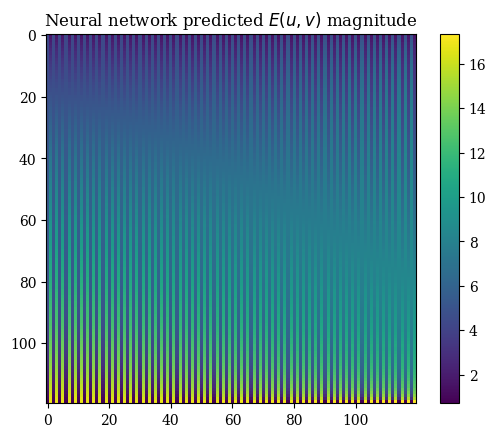

In [465]:
plt.title("Neural network predicted $E(u, v)$ magnitude")
plt.imshow(correct_axes(magnitude(E_u_nn, E_v_nn)), interpolation="none")
plt.colorbar()
plt.show()

And upon inspection you immediately see why. If we take a look at our raw labels we see a bunch of discontinuities at the border where the two $120 \times 120$ arrays meet:

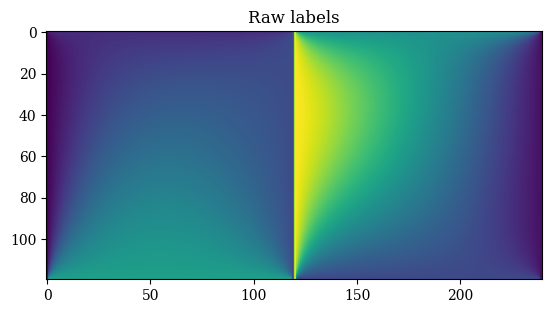

In [478]:
plt.title("Raw labels")
plt.imshow(trainY)
plt.show()

This is absolutely not what we want. So instead, just as with the interpolation method it might be a much better idea to train _two_ separate neural networks, one for $E_u$ and one for $E_v$, so that the solutions are smooth and continuous which are much easier for neural networks to work with.

In addition, we want to directly map from a vector of $[(u_1, v_1), (u_2, v_2), (u_3, v_3), \dots (u_n, v_n)]$ of shape $(120, 2)$, to an output of shape $(120, 120)$ for each of the neural networks. It may be the case that mapping from the meshgrid versions of $(u, v)$ leads to the banding behavior.

In [575]:
class NNInterpolation:
    def __init__(self, trainX=(u_of_x(x), v_of_y(y)), trainY=(transform_u, transform_v)):
        E_u, E_v = trainY
        u, v = trainX
        self.original_E_u = E_u
        self.original_E_v = E_v
        # we preprecess by running the train features through a
        # data scaler to rescale & regularize data for training
        # this should only be run once
        # also no train/validation split because we're just
        # using the NN as a model for the numerical solution
        self.u_scaler = StandardScaler()
        self.v_scaler = StandardScaler()
        self.u_scaler.fit(u)
        self.v_scaler.fit(v)
        # preprocess the original data
        self.U = self.u_scaler.transform(U)
        self.V = self.v_scaler.transform(V)
    
    def train(self, learning_rate="adaptive", max_iter=2500):
        print("Training neural network...")
        self.nn_u = MLPRegressor(random_state=1, learning_rate=learning_rate, max_iter=max_iter).fit(self.U, self.original_E_u)
        self.nn_v = MLPRegressor(random_state=1, learning_rate=learning_rate, max_iter=max_iter).fit(self.V, self.original_E_v)
    
    def check_shapes(self, U, V):
        print("Checking dimensionality (must be 2D)...")
        assert U.ndim == 2
        assert V.ndim == 2

In [574]:
NNInterpolation.check_shapes??

In [572]:
NNInterpolation.train??

In [566]:
import inspect

In [568]:
NNInterpolation??

In [570]:
NNInterpolation.__init__??

In [537]:
u_of_x(x).shape

(120,)

In [532]:
nn_model = NNInterpolation()

In [533]:
nn_model.train()

Training neural network...
Training done.


In [534]:
E_u_nn, E_v_nn = nn_model.predict(U, V)

Checking dimensionality (must be 2D)...
Prediction done.


In [535]:
E_u_nn

array([[2.01138998, 1.86690161, 1.74718789, ..., 6.32487804, 6.49387085,
        6.99735416],
       [2.00986918, 1.86924576, 1.75353596, ..., 6.33483618, 6.50349997,
        6.99395941],
       [2.00833554, 1.8716097 , 1.7599376 , ..., 6.34487835, 6.51321036,
        6.99053601],
       ...,
       [1.9872677 , 2.29437159, 2.50118752, ..., 5.97543901, 6.24825236,
        7.02125018],
       [1.98488274, 2.29898663, 2.51126242, ..., 5.95599947, 6.2333722 ,
        7.04054042],
       [1.98247765, 2.30364061, 2.52142233, ..., 5.93639589, 6.21836648,
        7.05999344]])

In [521]:
tempvar = correct_axes(magnitude(E_u_nn, E_v_nn))

In [522]:
tempvar

array([[13.17349731, 13.14022857, 13.10667982, ...,  7.03593636,
         6.96330678,  6.89073087],
       [17.87824497, 17.83776211, 17.79693773, ...,  9.72911769,
         9.61872568,  9.51005254],
       [18.69818368, 18.65985073, 18.62119542, ..., 11.22344235,
        11.12683663, 11.02825583],
       ...,
       [14.68463215, 14.65655124, 14.62823338, ...,  8.31285582,
         8.21379658,  8.11285528],
       [10.50039442, 10.47635114, 10.45210583, ...,  5.53003919,
         5.46163555,  5.39463648],
       [ 6.5736406 ,  6.55746652,  6.54116205, ...,  3.74811291,
         3.71626595,  3.68339129]])

Hmm, that's interesting, you still see the banding, the outputs are not smooth and jump between two values.

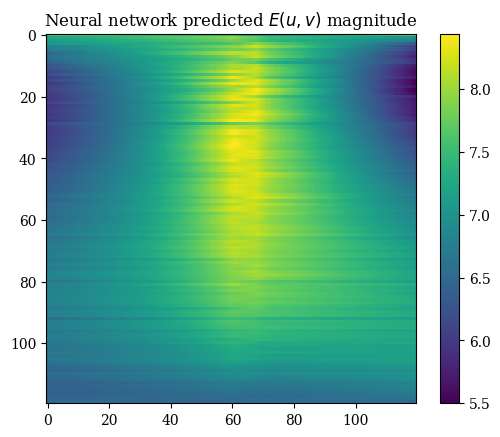

In [530]:
plt.title("Neural network predicted $E(u, v)$ magnitude")
plt.imshow(correct_axes(magnitude(E_u_nn, E_v_nn)))
plt.colorbar()
plt.show()

In [565]:
#compare_uv_bcs(Emag_interp=magnitude(E_u_nn, E_v_nn), desc="Comparison of numerical and neural-network fit\n solutions evaluted on boundaries")

It appears that the neural network fit approach was far superior at obtaining a good fit that respected the boundary conditions, so it will be the one we will use.

The question now is with the backwards transforms, which, like the forward transforms, preserves the features of the function, including having constant boundary conditions just like the original boundary conditions.

Finally, we evaluate the original function $\mathbf{E}(x, y)$ through the interpolated version of $\mathbf{E}'(u, v)$, via $\mathbf{E}(x, y) = \mathbf{E}'(x(u), y(v))$. We have $x(u) = \ln u, y(v) = \ln v$. Evaluating these on the arrays of $u$ and $v$ recovers $\mathbf{E}(x, y)$.

In [104]:
# backwards transforms
x_of_u = lambda u: np.log(u)
y_of_v = lambda v: np.log(v)

In [105]:
E_x = E_u(x_of_u(U), y_of_v(V))
E_y = E_v(x_of_u(U), y_of_v(V))

In [106]:
E_y.shape

(120, 120)

In [107]:
def plotE_xyspace(x=X, y=Y, E_x=E_x, E_y=E_y, desc=None, opacity=0.5):
    vec_density = 6 # plot one vector for every 10 points
    contour_levels = 12 # number of contours (filled isocurves) to plot
    E_mag = magnitude(E_x, E_y)
    levels = np.linspace(E_mag.min(), E_mag.max(), contour_levels)
    # plot the filled isocurves
    plt.contourf(x, y, E_mag, levels=levels)
    # plot the vectors
    plt.quiver(x[::vec_density, ::vec_density], y[::vec_density, ::vec_density], E_x[::vec_density, ::vec_density], E_y[::vec_density, ::vec_density], scale=400, headwidth=2, color=(1, 1, 1, opacity))
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    if not desc:
        plt.title(r"$\mathbf{E}(u, v)$ transformed back to $(x, y)$ coordinates")
    else:
        plt.title(desc)
    plt.colorbar()
    plt.show()

$$
E_u(u, 1) = 2, E_u(u, e) = 7, E_u(1, v) = 0.5, E_u(e, v) = \pi \\
E_v(u, 1) = 2\pi, E_v(u, e) = 3, E_v(1, v) = 12, E_v(e, v) = 1
$$

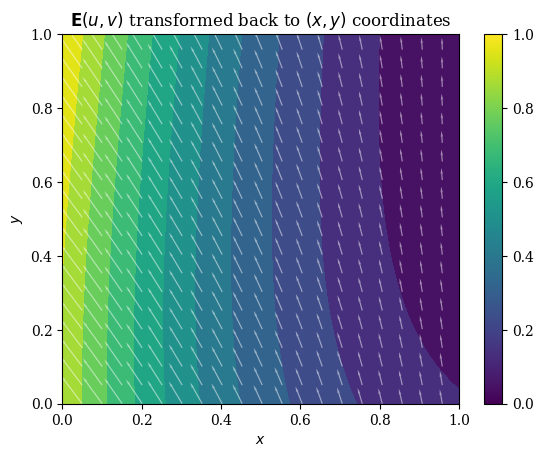

In [108]:
plotE_xyspace()

Compare these to the analytical boundary conditions:

In [420]:
np.log(1)

0.0

In [425]:
E_x[0, :]

array([-23.27206046, -23.27213486, -23.27235706, -23.27272562,
       -23.27323908, -23.27389596, -23.27469482, -23.27563419,
       -23.27671262, -23.27792863, -23.27928078, -23.28076759,
       -23.28238762, -23.2841394 , -23.28602146, -23.28803236,
       -23.29017062, -23.2924348 , -23.29482342, -23.29733503,
       -23.29996817, -23.30272137, -23.30559319, -23.30858215,
       -23.31168679, -23.31490567, -23.31823731, -23.32168025,
       -23.32523304, -23.32889421, -23.33266231, -23.33653588,
       -23.34051344, -23.34459355, -23.34877475, -23.35305557,
       -23.35743455, -23.36191023, -23.36648115, -23.37114586,
       -23.37590289, -23.38075077, -23.38568806, -23.39071329,
       -23.395825  , -23.40102173, -23.40630202, -23.41166441,
       -23.41710744, -23.42262964, -23.42822956, -23.43390574,
       -23.43965672, -23.44548104, -23.45137723, -23.45734384,
       -23.4633794 , -23.46948247, -23.47565156, -23.48188523,
       -23.48818202, -23.49454046, -23.5009591 , -23.50

$$
E_x(x, 0) = 2, E_x(x, 1) = 7, E_x(0, y) = 0.5, E_x(1, y) = \pi \\
E_y(x, 0) = 2\pi, E_y(x, 1) = 3, E_y(0, y) = 12, E_y(1, y) = 1
$$

In [395]:
cov_u.shape

(9, 9)

In [ ]:
def plotE_uvspace(u=U, v=V, Usol=transform_u, Vsol=transform_v, desc=None, opacity=0.5):
    vec_density = 6 # plot one vector for every 10 points
    contour_levels = 12 # number of contours (filled isocurves) to plot
    transform_mag = norm(transform_u, transform_v)
    levels = np.linspace(transform_mag.min(), transform_mag.max(), contour_levels)
    # plot the filled isocurves
    plt.contourf(u, v, transform_mag, levels=levels)
    # plot the vectors
    plt.quiver(u[::vec_density, ::vec_density], v[::vec_density, ::vec_density], Usol[::vec_density, ::vec_density], Vsol[::vec_density, ::vec_density], scale=400, headwidth=2, color=(1, 1, 1, opacity))
    plt.xlabel("$u$")
    plt.ylabel("$v$")
    if not desc:
        plt.title(r"$\mathbf{E}(u, v)$ solved on unit square in $(u, v)$ coordinates")
    else:
        plt.title(desc)
    plt.colorbar()
    plt.show()

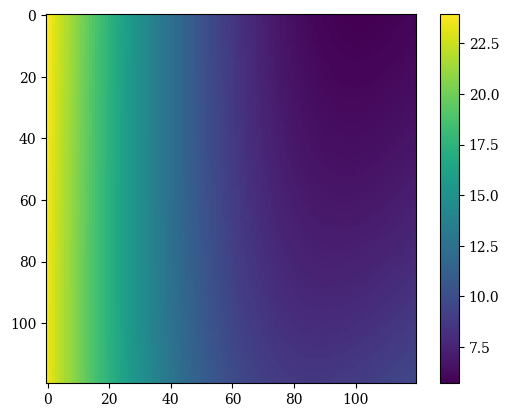

In [446]:
E_xy_mag = correct_axes(magnitude(E_x, E_y))
plt.imshow(E_xy_mag)
plt.colorbar()
plt.show()

In [256]:
print(top)
print(right)
print(bottom)
print(left)

7.615773105863909
3.296908309475615
6.59381661895123
12.010412149464313


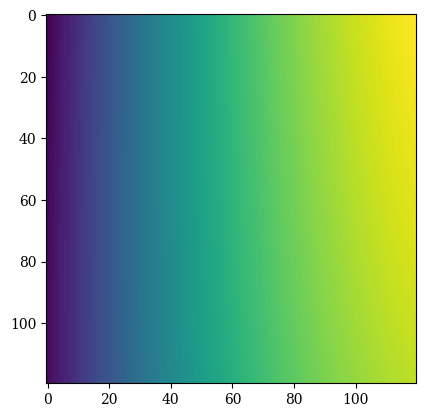

In [418]:
plt.imshow(correct_axes(E_x))
plt.show()

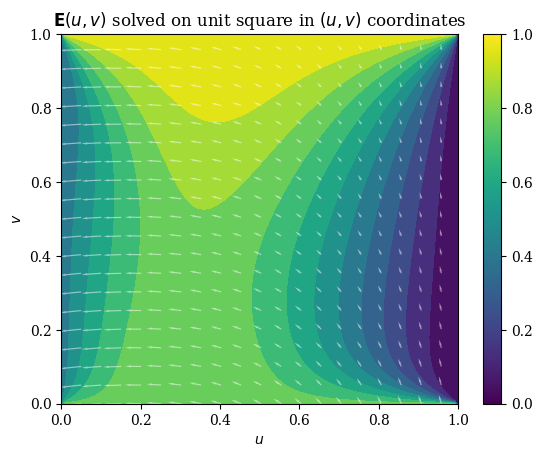

In [434]:
plotE_uvspace(u=X, v=Y, Usol=E_x, Vsol=E_y, desc="")

In [400]:
E_x[:, 0]

array([-23.27206046, -22.95405629, -22.63890391, -22.32659163,
       -22.01710774, -21.71044055, -21.40657835, -21.10550945,
       -20.80722214, -20.51170472, -20.2189455 , -19.92893277,
       -19.64165484, -19.3571    , -19.07525655, -18.7961128 ,
       -18.51965704, -18.24587758, -17.9747627 , -17.70630072,
       -17.44047993, -17.17728864, -16.91671514, -16.65874773,
       -16.40337471, -16.15058438, -15.90036505, -15.652705  ,
       -15.40759255, -15.16501599, -14.92496363, -14.68742375,
       -14.45238466, -14.21983467, -13.98976206, -13.76215515,
       -13.53700223, -13.3142916 , -13.09401155, -12.8761504 ,
       -12.66069644, -12.44763797, -12.23696328, -12.02866069,
       -11.82271849, -11.61912497, -11.41786845, -11.21893721,
       -11.02231957, -10.82800381, -10.63597824, -10.44623116,
       -10.25875086, -10.07352566,  -9.89054384,  -9.70979371,
        -9.53126357,  -9.35494172,  -9.18081645,  -9.00887607,
        -8.83910888,  -8.67150318,  -8.50604726,  -8.34

In [444]:
E_x[:, 0]

array([-23.27206046, -22.95405629, -22.63890391, -22.32659163,
       -22.01710774, -21.71044055, -21.40657835, -21.10550945,
       -20.80722214, -20.51170472, -20.2189455 , -19.92893277,
       -19.64165484, -19.3571    , -19.07525655, -18.7961128 ,
       -18.51965704, -18.24587758, -17.9747627 , -17.70630072,
       -17.44047993, -17.17728864, -16.91671514, -16.65874773,
       -16.40337471, -16.15058438, -15.90036505, -15.652705  ,
       -15.40759255, -15.16501599, -14.92496363, -14.68742375,
       -14.45238466, -14.21983467, -13.98976206, -13.76215515,
       -13.53700223, -13.3142916 , -13.09401155, -12.8761504 ,
       -12.66069644, -12.44763797, -12.23696328, -12.02866069,
       -11.82271849, -11.61912497, -11.41786845, -11.21893721,
       -11.02231957, -10.82800381, -10.63597824, -10.44623116,
       -10.25875086, -10.07352566,  -9.89054384,  -9.70979371,
        -9.53126357,  -9.35494172,  -9.18081645,  -9.00887607,
        -8.83910888,  -8.67150318,  -8.50604726,  -8.34

Recall that our original boundary conditions were given by:

$$
E_x(x, 0) = 2, E_x(x, 1) = 7, E_x(0, y) = 0.5, E_x(1, y) = \pi \\
E_y(x, 0) = 2\pi, E_y(x, 1) = 3, E_y(0, y) = 12, E_y(1, y) = 1
$$

We can calculate the magnitude of the field via $E(x, y) = \|\mathbf{E}(x, y)\|$. We can also validate this magnitude through the provided boundary conditions. For instance, $E(x, 0) = \sqrt{E_x(x, 0) + E_y(x, 0)}$. The full set of the boundary conditions of the magnitude field $E$ are:

In [448]:
E_xy_mag[:, -1]

array([5.97396038, 5.98854118, 6.00332326, 6.01830852, 6.03349888,
       6.0488963 , 6.06450269, 6.08032003, 6.09635026, 6.11259535,
       6.12905728, 6.14573804, 6.16263962, 6.17976402, 6.19711326,
       6.21468934, 6.23249429, 6.25053015, 6.26879896, 6.28730276,
       6.30604361, 6.32502356, 6.3442447 , 6.36370909, 6.38341881,
       6.40337596, 6.42358263, 6.44404091, 6.46475293, 6.48572078,
       6.5069466 , 6.5284325 , 6.55018061, 6.57219309, 6.59447205,
       6.61701966, 6.63983807, 6.66292943, 6.68629591, 6.70993968,
       6.7338629 , 6.75806777, 6.78255645, 6.80733114, 6.83239404,
       6.85774733, 6.88339321, 6.90933391, 6.93557161, 6.96210854,
       6.98894691, 7.01608895, 7.04353687, 7.07129292, 7.09935931,
       7.12773829, 7.1564321 , 7.18544299, 7.21477319, 7.24442495,
       7.27440054, 7.3047022 , 7.3353322 , 7.3662928 , 7.39758626,
       7.42921486, 7.46118086, 7.49348654, 7.52613417, 7.55912604,
       7.59246442, 7.6261516 , 7.66018987, 7.69458152, 7.72932

In [405]:
bottom = norm([2, 2*np.pi])
top = norm([7, 3])
left = norm([0.5, 12])
right = norm([np.pi, 1])

In [256]:
print(top)
print(right)
print(bottom)
print(left)

7.615773105863909
3.296908309475615
6.59381661895123
12.010412149464313


In [181]:
7**2 + 3**2

58

In [182]:
58/4

14.5

In [185]:
144*4

576

In [186]:
576/4 + 1/4

144.25

For the backwards transform, as we need to evaluate the solution $\mathbf{E}'(u, v)$ as a _function_ to be able to get back the solution in familiar $(x, y)$ coordinates, we will use a quadratic interpolation provided by SciPy's curve-fit routines.

In [ ]:
# Use norm()